In [ ]:
üğğfrom google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FOLDERNAME = 'Colab Notebooks/RLHF_final'
%cd /content/drive/My\ Drive/$FOLDERNAME/
!ls

/content/drive/My Drive/Colab Notebooks/RLHF_final
 best_model_cross_attention.pth   extract_features.py
 best_model_final.h5		 'extract_features.py adlı dosyanın kopyası'
 best_model.h5			  load_data.py
 best_model_seperated_nn.h5	  __pycache__
 data


In [ ]:
!python extract_features.py --add_augment

Namespace(add_augment=True, batch_size=32)
Extracting 270 degree rotated images for im1...
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100% 171M/171M [00:01<00:00, 154MB/s]
Extracting features: 100% 66/66 [00:10<00:00,  6.17it/s]
im1_270_degree shape: (2084, 2048, 1, 1)
Extracting 27

In [ ]:
%cd /content/drive/My\ Drive/$FOLDERNAME/
from load_data import load_json_data

# Load data
data = load_json_data("data/result.json", 1000, 1519)
data[-1]

/content/drive/My Drive/Colab Notebooks/RLHF_final


[{'filename': '03573_0',
  'sentence1': 'A building has been constructed on the empty area at the edge of the scene ',
  'sentence2': 'The roof of the buildings at the edge of the scene has turned from blue to gray ',
  'sentence3': 'the roof of the buildings at the edge of the scene has turned from blue to gray ',
  'slider1': -5,
  'slider2': -2,
  'slider3': -2},
 {'filename': '03573_1',
  'sentence1': 'A building has been constructed on the green area at the edge of the scene ',
  'sentence2': 'The blue building at the edge of the scene has turned blue ',
  'sentence3': 'The green area at the edge of the scene has turned blue ',
  'slider1': 4,
  'slider2': -5,
  'slider3': 1},
 {'filename': '03573_2',
  'sentence1': 'many trees appear on the bareland at the corner of the scene ',
  'sentence2': 'the bareland appears on the edge of the scene ',
  'sentence3': 'bareland appears on the buildings at the corner of the scene ',
  'slider1': -5,
  'slider2': -4,
  'slider3': -5},
 {'file

In [ ]:
import numpy as np

features_im1 = np.load(f"data/features/im1.npy")
features_im1 = features_im1.reshape((2084, 2048))

features_im2 = np.load(f"data/features/im2.npy")
features_im2 = features_im2.reshape((2084, 2048))

features_im1.shape, features_im2.shape

((2084, 2048), (2084, 2048))

#### Encoding The Sentences With BERT model

In [ ]:
import numpy as np
import torch
import tqdm
from transformers import BertTokenizer, BertModel
import os

if os.path.exists("data/features/sentence_embeddings.npy"):
    sentence_embeddings = np.load("data/features/sentence_embeddings.npy")
    #sentence_embeddings = np.concatenate((sentence_embeddings, sentence_embeddings, sentence_embeddings, sentence_embeddings), axis=0)
    print(sentence_embeddings.shape)
    print("Sentence embeddings loaded from file")
else:

  def bert_encode(sentences, bert_model, tokenizer, device, batch_size=32):
      bert_model.to(device)
      bert_model.eval()  # Modeli değerlendirme modunda çalıştır

      # Tüm cümleleri batch'ler halinde işle
      all_sentence_embeddings = []
      for i in tqdm.tqdm(range(0, len(sentences), batch_size), desc="BERT Encoding"):
          batch_sentences = sentences[i:i+batch_size]
          encoded = tokenizer.batch_encode_plus(
              batch_sentences,
              add_special_tokens=True,
              max_length=512,
              padding='max_length',
              truncation=True,
              return_attention_mask=True,
              return_tensors='pt'
          )

          input_ids = encoded['input_ids'].to(device)
          attention_mask = encoded['attention_mask'].to(device)

          with torch.no_grad():
              outputs = bert_model(input_ids, attention_mask=attention_mask)
              sentence_embeddings = outputs[0][:, 0, :]  # [CLS] token'ın çıktısını al
              all_sentence_embeddings.extend(sentence_embeddings.cpu().numpy())

      return np.array(all_sentence_embeddings)

  def collect_all_sentences(data):
      all_sentences = []
      sentence_lengths = []
      for data_point in data:
          for data_point_caption in data_point:
              for i in range(1, 4):
                  all_sentences.append(data_point_caption["sentence" + str(i)])
      return all_sentences


  # Load BERT model
  bert_model = BertModel.from_pretrained('bert-base-uncased')
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Collect all sentences
  all_sentences = collect_all_sentences(data)

  # Encode sentences
  sentence_embeddings = bert_encode(all_sentences, bert_model, tokenizer, device, batch_size=128)

  #free gpu memory
  if torch.cuda.is_available():
      torch.cuda.empty_cache()

  import os
  if not os.path.exists("data/features"):
      os.makedirs("data/features")
  np.save("data/features/sentence_embeddings.npy", sentence_embeddings)


  sentence_embeddings.shape

(6252, 768)
Sentence embeddings loaded from file


#### Encoding The Sentences With GPT2

In [ ]:
import numpy as np
import torch
import tqdm
from transformers import GPT2Tokenizer, GPT2Model
import os

if os.path.exists("data/features/sentence_embeddings.npy"):
    sentence_embeddings = np.load("data/features/sentence_embeddings.npy")
    print("Sentence embeddings loaded from file")
else:
    def gpt2_encode(sentences, gpt2_model, tokenizer, device, batch_size=32):
        gpt2_model.to(device)
        gpt2_model.eval()
        tokenizer.pad_token = tokenizer.eos_token
        # Process all sentences in batches
        all_sentence_embeddings = []
        for i in tqdm.tqdm(range(0, len(sentences), batch_size), desc="GPT-2 Encoding"):
            batch_sentences = sentences[i:i + batch_size]
            encoded = tokenizer.batch_encode_plus(
                batch_sentences,
                add_special_tokens=True,
                max_length=512,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )

            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            with torch.no_grad():
                outputs = gpt2_model(input_ids, attention_mask=attention_mask)
                # We take the last hidden states of the model
                sentence_embeddings = outputs.last_hidden_state.mean(dim=1)
                all_sentence_embeddings.extend(sentence_embeddings.cpu().numpy())

        return np.array(all_sentence_embeddings)

    def collect_all_sentences(data):
      all_sentences = []
      sentence_lengths = []
      for data_point in data:
          for data_point_caption in data_point:
              for i in range(1, 4):
                  all_sentences.append(data_point_caption["sentence" + str(i)])
      return all_sentences

    # Load GPT-2 model
    gpt2_model = GPT2Model.from_pretrained('gpt2')
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Assuming 'collect_all_sentences' and 'data' are defined as in your BERT example
    all_sentences = collect_all_sentences(data)

    # Encode sentences
    sentence_embeddings = gpt2_encode(all_sentences, gpt2_model, tokenizer, device, batch_size=32)

    # Free GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Save embeddings
    if not os.path.exists("data/features"):
        os.makedirs("data/features")
    np.save("data/features/sentence_embeddings.npy", sentence_embeddings)

    sentence_embeddings.shape

#### Encoding the sentences with RoBERTa

In [ ]:
import numpy as np
import torch
import tqdm
from transformers import RobertaModel, RobertaTokenizer
import os

if os.path.exists("data/features/sentence_embeddings.npy"):
    sentence_embeddings = np.load("data/features/sentence_embeddings.npy")
    print("Sentence embeddings loaded from file")
else:
    def roberta_encode(sentences, model, tokenizer, device, batch_size=32):
        model.to(device)
        model.eval()

        # Process all sentences in batches
        all_sentence_embeddings = []
        for i in tqdm.tqdm(range(0, len(sentences), batch_size), desc="RoBERTa Encoding"):
            batch_sentences = sentences[i:i + batch_size]
            encoded = tokenizer.batch_encode_plus(
                batch_sentences,
                add_special_tokens=True,
                max_length=512,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )

            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                # We take the last hidden states of the model
                sentence_embeddings = outputs.last_hidden_state.mean(dim=1)
                all_sentence_embeddings.extend(sentence_embeddings.cpu().numpy())

        return np.array(all_sentence_embeddings)

    def collect_all_sentences(data):
      all_sentences = []
      sentence_lengths = []
      for data_point in data:
          for data_point_caption in data_point:
              for i in range(1, 4):
                  all_sentences.append(data_point_caption["sentence" + str(i)])
      return all_sentences

    roberta_model  = RobertaModel.from_pretrained('roberta-base')
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_sentences = collect_all_sentences(data)

    # Encode sentences
    sentence_embeddings = roberta_encode(all_sentences, roberta_model, tokenizer, device, batch_size=32)

    # Free GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Save embeddings
    if not os.path.exists("data/features"):
        os.makedirs("data/features")
    np.save("data/features/sentence_embeddings.npy", sentence_embeddings)

    sentence_embeddings.shape

In [ ]:
!pip install sentencepiece

#### Encoding the sentences with XLNet NLP Model

In [ ]:
import numpy as np
import torch
import tqdm
from transformers import XLNetTokenizer, XLNetModel
import os

if os.path.exists("data/features/sentence_embeddings.npy"):
    sentence_embeddings = np.load("data/features/sentence_embeddings.npy")
    print("Sentence embeddings loaded from file")
else:
    def xlnet_encode(sentences, model, tokenizer, device, batch_size=32):
        model.to(device)
        model.eval()

        # Process all sentences in batches
        all_sentence_embeddings = []
        for i in tqdm.tqdm(range(0, len(sentences), batch_size), desc="RoBERTa Encoding"):
            batch_sentences = sentences[i:i + batch_size]
            encoded = tokenizer.batch_encode_plus(
                batch_sentences,
                add_special_tokens=True,
                max_length=512,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )

            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                # We take the last hidden states of the model
                sentence_embeddings = outputs.last_hidden_state.mean(dim=1)
                all_sentence_embeddings.extend(sentence_embeddings.cpu().numpy())

        return np.array(all_sentence_embeddings)

    def collect_all_sentences(data):
      all_sentences = []
      sentence_lengths = []
      for data_point in data:
          for data_point_caption in data_point:
              for i in range(1, 4):
                  all_sentences.append(data_point_caption["sentence" + str(i)])
      return all_sentences

    xlnet_model = XLNetModel.from_pretrained('xlnet-base-cased')
    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_sentences = collect_all_sentences(data)

    # Encode sentences
    sentence_embeddings = xlnet_encode(all_sentences, xlnet_model, tokenizer, device, batch_size=32)

    # Free GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Save embeddings
    if not os.path.exists("data/features"):
        os.makedirs("data/features")
    np.save("data/features/sentence_embeddings.npy", sentence_embeddings)

    sentence_embeddings.shape

#### Prepare Training Data

In [ ]:
combined_features = []
combined_labels = []
slider_values = []

for data_point in data:
    for i in range(0, 4):
        for j in range(1, 4):
            slider_values.append(data_point[i]["slider" + str(j)])

slider_values = np.array(slider_values)
#slider_values = np.concatenate((slider_values, slider_values, slider_values, slider_values), axis=0)
slider_values.shape

(6252,)

#### Categorize the data between 0 and 2
* If you want to reduce prediction range then run given below cell

In [ ]:
def categorize_labels(value):
    if value <= -2:
        return 0
    elif value >= 2:
        return 2
    else:
        return 1

slider_values = np.array([categorize_labels(value) for value in slider_values])
slider_values[0]

2

#### Categorize the data for binary classification
* If you want to categorize the data with binary classification then run the below cell

In [ ]:
def categorize_labels(value):
    if value < 0:
        return 0
    else:
        return 1

slider_values = np.array([categorize_labels(value) for value in slider_values])
slider_values[0]

1

### Section 1
#### If you want to create neural network using combined data then run below cell
* If you want to create it seperately, then go to section 2

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.nn.functional import normalize

# Assuming the following shapes
# before_feature.shape = (2084, 2048)
# after_feature.shape = (2084, 2048)
# bert_encoded_sentences.shape = (6252, 768)
# slider_values.shape = (6252,)

before_features_tensor = torch.tensor(features_im1, dtype=torch.float32)
after_features_tensor = torch.tensor(features_im2, dtype=torch.float32)
bert_encoded_sentences_tensor = torch.tensor(sentence_embeddings, dtype=torch.float32)

before_features_norm = normalize(before_features_tensor, p = 2, dim = 1)
after_features_norm = normalize(after_features_tensor, p = 2, dim = 1)
sentences_norm = normalize(bert_encoded_sentences_tensor, p=2, dim=1)

before_features_repeated = before_features_norm.repeat_interleave(3, dim=0)
after_features_repeated = after_features_norm.repeat_interleave(3, dim=0)

combined_features = torch.cat([before_features_repeated, after_features_repeated, sentences_norm], dim = 1)

combined_features = combined_features.numpy()
print("shape is : ", combined_features.shape[0])
indices = np.arange(combined_features.shape[0])
print("indices: ", indices)
# First, split indices into training + validation/test and then validation/test
train_indices, testVal_indices = train_test_split(indices, test_size=0.3, random_state=42, shuffle=True)
val_indices, test_indices = train_test_split(testVal_indices, test_size=0.66, random_state=42, shuffle=True)

# Use these indices to create the datasets
X_train = combined_features[train_indices]
y_train = slider_values[train_indices]

X_val = combined_features[val_indices]
y_val = slider_values[val_indices]

X_test = combined_features[test_indices]
y_test = slider_values[test_indices]

# Now you have the indices corresponding to each set
print("Indices of X_train:", train_indices)
print("Shape of X_train:", X_train.shape)

shape is :  6252
indices:  [   0    1    2 ... 6249 6250 6251]
Indices of X_train: [3547  238   92 ... 5226 5390  860]
Shape of X_train: (4376, 4864)


#### Data Augmentation
* If you want to add data to train data set, run this below cell

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.nn.functional import normalize

features_im1_1 = np.load(f"data/features/im1_90_degree.npy")
features_im1_1 = features_im1_1.reshape((2084, 2048))

features_im1_2 = np.load(f"data/features/im1_180_degree.npy")
features_im1_2 = features_im1_2.reshape((2084, 2048))

features_im1_3 = np.load(f"data/features/im1_270_degree.npy")
features_im1_3 = features_im1_3.reshape((2084, 2048))

features_im2_1 = np.load(f"data/features/im2_90_degree.npy")
features_im2_1 = features_im2_1.reshape((2084, 2048))

features_im2_2 = np.load(f"data/features/im2_180_degree.npy")
features_im2_2 = features_im2_2.reshape((2084, 2048))

features_im2_3 = np.load(f"data/features/im2_270_degree.npy")
features_im2_3 = features_im2_3.reshape((2084, 2048))


sentence_embeddings = np.load("data/features/sentence_embeddings.npy")
print("Sentence Shape: ", sentence_embeddings.shape)

augmented_slider_values = []

for data_point in data:
    for i in range(0, 4):
        for j in range(1, 4):
            augmented_slider_values.append(data_point[i]["slider" + str(j)])

augmented_slider_values = np.array(augmented_slider_values)
augmented_slider_values = np.concatenate((augmented_slider_values, augmented_slider_values, augmented_slider_values), axis=0)
print("Slider Value Shape: ", augmented_slider_values.shape)

def categorize_labels_binary(value):
    if value < 0:
        return 0
    else:
        return 1

def categorize_labels_multiple_class(value):
    if value <= -2:
        return 0
    elif value >= 2:
        return 2
    else:
        return 1

augmented_slider_values = np.array([categorize_labels_binary(value) for value in augmented_slider_values])


def prepare_augmented_tensors(features_im1, features_im2, sentence_embeddings):
    before_features_tensor = torch.tensor(features_im1, dtype=torch.float32)
    after_features_tensor = torch.tensor(features_im2, dtype=torch.float32)
    bert_encoded_sentences_tensor = torch.tensor(sentence_embeddings, dtype=torch.float32)

    before_features_norm = normalize(before_features_tensor, p=2, dim=1)
    after_features_norm = normalize(after_features_tensor, p=2, dim=1)
    sentences_norm = normalize(bert_encoded_sentences_tensor, p=2, dim=1)

    before_features_repeated = before_features_norm.repeat_interleave(3, dim=0)
    after_features_repeated = after_features_norm.repeat_interleave(3, dim=0)
    concatenated_datas = torch.cat([before_features_repeated, after_features_repeated, sentences_norm], dim = 1).numpy()
    return concatenated_datas

# Prepare augmented features
augmented_features_90 = prepare_augmented_tensors(features_im1_1, features_im2_1, sentence_embeddings)
augmented_features_180 = prepare_augmented_tensors(features_im1_2, features_im2_2, sentence_embeddings)
augmented_features_270 = prepare_augmented_tensors(features_im1_3, features_im2_3, sentence_embeddings)

# Augmenting only the training indices
X_train_augmented_90 = augmented_features_90[train_indices]
X_train_augmented_180 = augmented_features_180[train_indices]
X_train_augmented_270 = augmented_features_270[train_indices]

# Augmenting slider values (assuming augmented_slider_values is prepared correctly)
y_train_augmented = augmented_slider_values[train_indices]

# Combine augmented data with original X_train and y_train
X_train_final = np.vstack([X_train, X_train_augmented_90, X_train_augmented_180, X_train_augmented_270])
y_train_final = np.hstack([y_train, y_train_augmented, y_train_augmented, y_train_augmented])

print("Final Train Shapes:", X_train_final.shape, y_train_final.shape)

Sentence Shape:  (6252, 768)
Slider Value Shape:  (18756,)
Final Train Shapes: (17504, 4864) (17504,)


#### Scaling The Data
* If you've already used normalizing the data via pytorch, don't use the StandardScaler

In [ ]:
# Scale the data
#TODO: torch normalize

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_test[0]

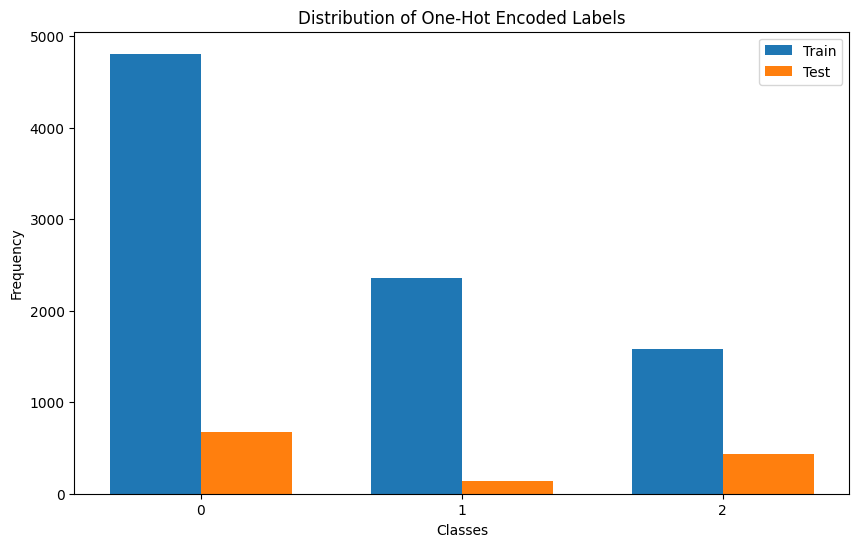

In [ ]:
# cover label to the categorical if necessary
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

y_train_categorical = to_categorical(y_train_final, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)
y_val_categorical = to_categorical(y_val)

train_distr = np.sum(y_train_categorical, axis=0)
test_distr = np.sum(y_test_categorical, axis=0)

# Set the labels for the classes
classes = ['0', '1', '2']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar positions
bar_width = 0.35
indices = np.arange(len(classes))

# Plotting both distributions side by side
train_bar = ax.bar(indices, train_distr, bar_width, label='Train')
test_bar = ax.bar(indices + bar_width, test_distr, bar_width, label='Test')

# Labeling
ax.set_xlabel('Classes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of One-Hot Encoded Labels')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(classes)
ax.legend()

# Display
plt.show()

#### Oversampling the minority classes

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# If y_train is one-hot encoded, convert it to single labels
# Assumes y_train_categorical is an array of one-hot encoded labels
y_train_labels = np.argmax(y_train_categorical, axis=1)

# Initialize SMOTE
smote = SMOTE()

# Fit SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_labels)

y_train_smote_categorical = tf.keras.utils.to_categorical(y_train_smote, num_classes=3)

y_train_smote_categorical.shape

#### Train The Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau

y_train_binary = (y_train_final == 1).astype(int)
y_test_binary = (y_test == 1).astype(int)
y_val_binary = (y_val == 1).astype(int)

model = Sequential()

# Adjusted model architecture
model.add(Dense(2048, input_dim=4864, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Output layer for binary
model.add(Dense(1, activation="sigmoid"))

# Output layer for multiple classification
#model.add(Dense(3, activation="softmax"))

#model.add(Dense(1, activation=None))

# Compile model with adjusted learning rate
optimizer = Adam(learning_rate=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001, verbose=1)

#binary
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#multiple classification
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Summary
model.summary()

# Fit model
history = model.fit(
    X_train_final, y_train_binary,
    epochs=500,
    batch_size=128,
    validation_data=(X_val, y_val_binary),
    callbacks=[early_stop, model_checkpoint, reduce_lr]
)

loss, accuracy = model.evaluate(X_test, y_test_binary)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              9963520   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - 21s 56ms/step - loss: 5.9238 - accuracy: 0.5448 - val_loss: 5.7836 - val_accuracy: 0.4349 - lr: 1.0000e-04
Epoch 2/500
137/137 [==============================] - 3s 24ms/step - loss: 5.6315 - accuracy: 0.6302 - val_loss: 5.5690 - val_accuracy: 0.4615 - lr: 1.0000e-04
Epoch 3/500
137/137 [==============================] - 3s 20ms/step - loss: 5.3594 - accuracy: 0.6884 - val_loss: 5.3444 - val_accuracy: 0.5557 - lr: 1.0000e-04
Epoch 4/500
137/137 [==============================] - 3s 18ms/step - loss: 5.0951 - accuracy: 0.7383 - val_loss: 5.1016 - val_accuracy: 0.6358 - lr: 1.0000e-04
Epoch 5/500
137/137 [==============================] - 3s 19ms/step - loss: 4.8335 - accuracy: 0.7800 - val_loss: 4.8696 - val_accuracy: 0.7017 - lr: 1.0000e-04
Epoch 6/500
137/137 [==============================] - 3s 19ms/step - loss: 4.5823 - accuracy: 0.8175 - val_loss: 4.7679 - val_accuracy: 0.6845 - lr: 1.0000e-04
Epoch 7/500
137/137 [========================

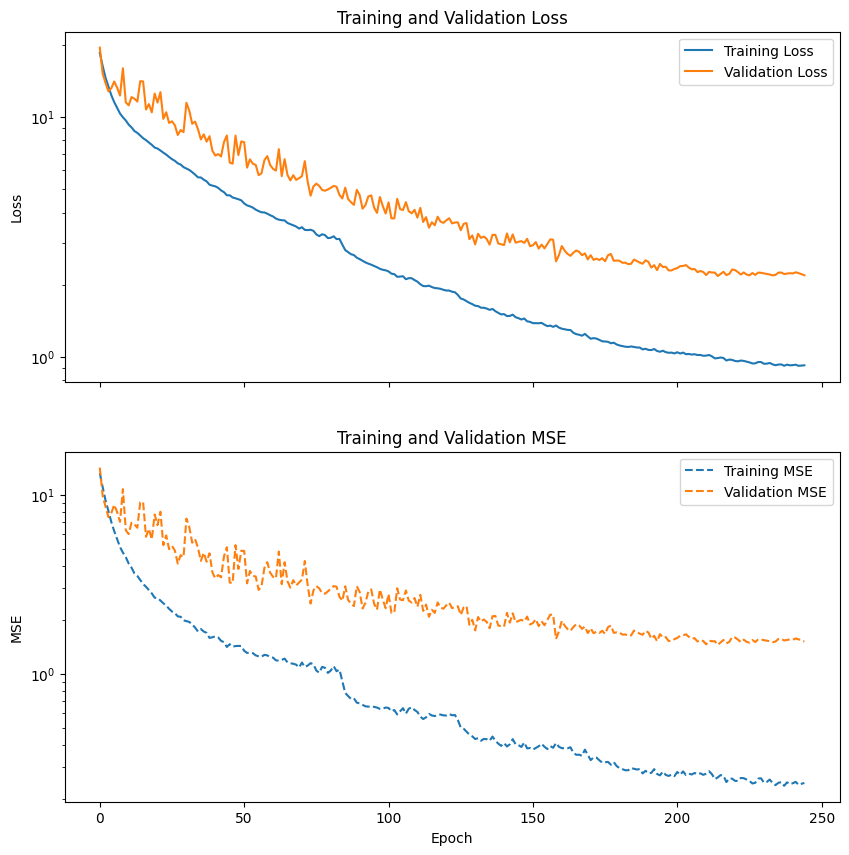

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert model history into a Pandas DataFrame
losses_df = pd.DataFrame(history.history)

# Plot the losses and MSE on separate subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# Loss plot
axes[0].plot(losses_df['loss'], label='Training Loss')
axes[0].plot(losses_df['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_yscale('log')

# MSE plot
axes[1].plot(losses_df['mean_squared_error'], label='Training MSE', linestyle='--')
axes[1].plot(losses_df['val_mean_squared_error'], label='Validation MSE', linestyle='--')
axes[1].set_title('Training and Validation MSE')
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].set_yscale('log')

# Show the plot
plt.show()


39/39 [==============================] - 0s 2ms/step
Mean Squared Error: 1.162805154481314
Mean Absolute Error: 0.5700960869241665


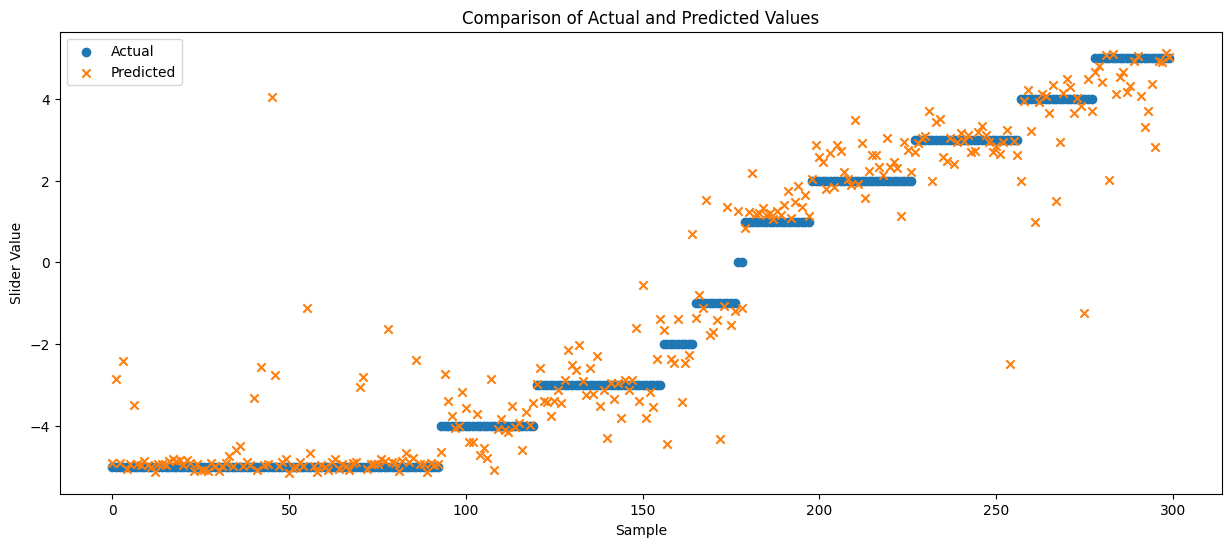

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(X_test).flatten()

# Calculate MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Sort by actual values while keeping track of predictions
N = 300
sorted_indices = np.argsort(y_test[:N])
sorted_actual = y_test[sorted_indices]
sorted_predicted = y_pred[sorted_indices]

# Plotting the first N test samples for comparison after sorting
plt.figure(figsize=(15, 6))
plt.scatter(range(N), sorted_actual, label='Actual', marker='o')
plt.scatter(range(N), sorted_predicted, label='Predicted', marker='x')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Slider Value')
plt.legend()
plt.show()

#### Plotting Accuracy and loss for categorical predicting

39/39 [==============================] - 0s 3ms/step
Accuracy: 0.6206618240516546
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       672
           1       0.25      0.34      0.29       134
           2       0.60      0.52      0.55       433

    accuracy                           0.62      1239
   macro avg       0.53      0.53      0.53      1239
weighted avg       0.63      0.62      0.62      1239



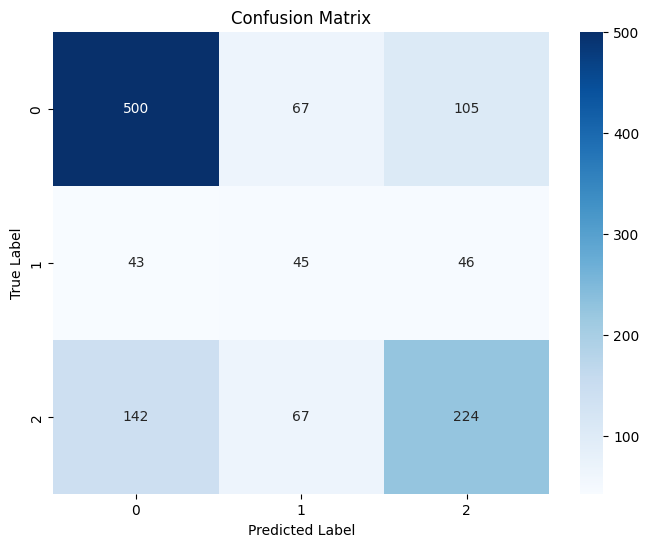

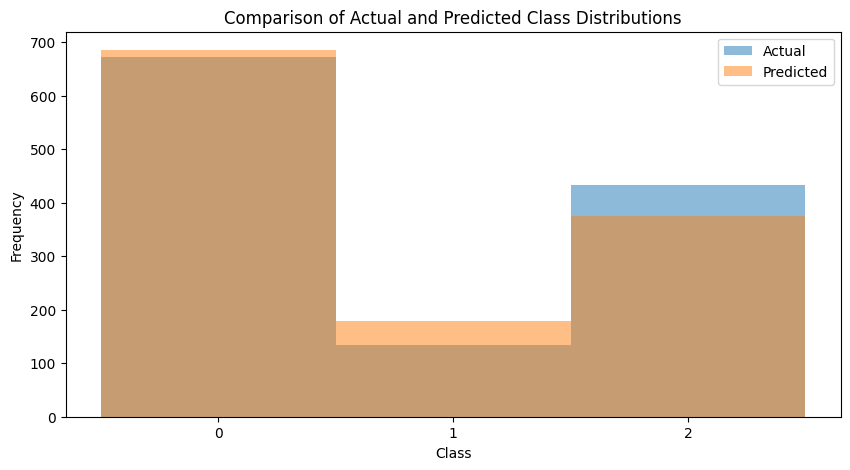

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)

# Convert predictions from one-hot encoded to class labels if necessary
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_categorical, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test_labels, y_pred_labels))

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(y_test_labels, bins=np.arange(-0.5, 3, 1), alpha=0.5, label='Actual')
plt.hist(y_pred_labels, bins=np.arange(-0.5, 3, 1), alpha=0.5, label='Predicted')
plt.xticks([0, 1, 2])
plt.title('Comparison of Actual and Predicted Class Distributions')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Binary classification confusion matrix

39/39 [==============================] - 0s 4ms/step
Accuracy: 0.7199354317998385
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       707
           1       0.68      0.65      0.67       532

    accuracy                           0.72      1239
   macro avg       0.71      0.71      0.71      1239
weighted avg       0.72      0.72      0.72      1239



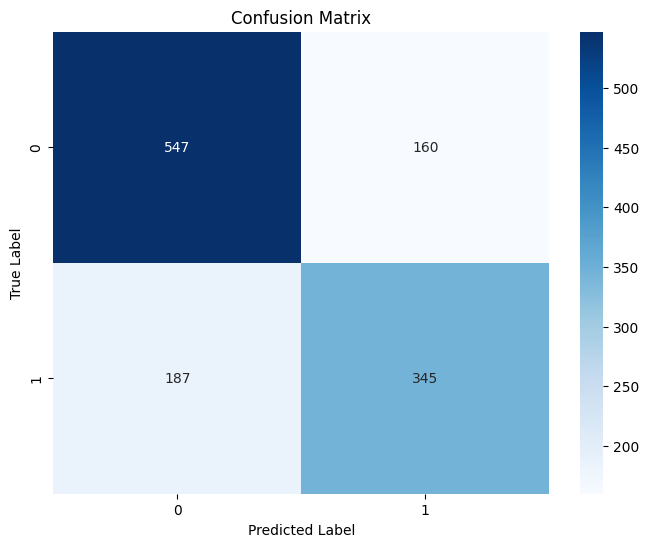

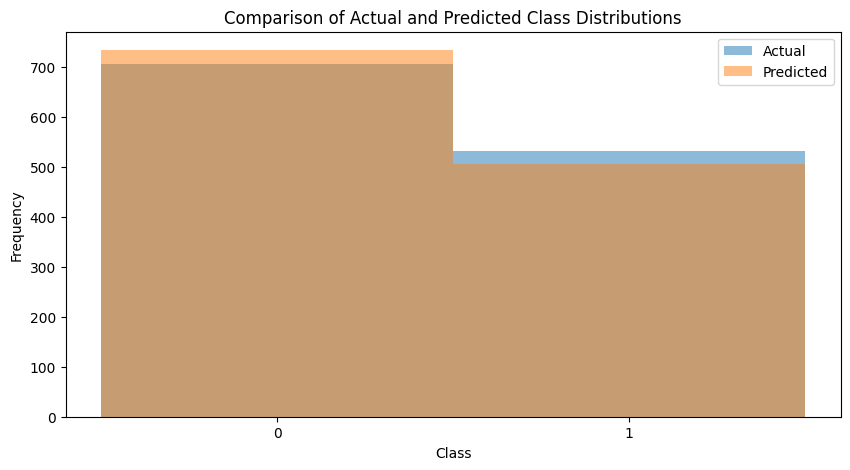

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Predict probabilities for the positive class
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels using a threshold (e.g., 0.5)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# y_test_binary should be the binary labels for your test set
y_test_binary = (y_test == 1).astype(int)

accuracy = accuracy_score(y_test_binary, y_pred_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test_binary, y_pred_labels))

cm = confusion_matrix(y_test_binary, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(y_test_binary, bins=np.arange(-0.5, 2, 1), alpha=0.5, label='Actual')
plt.hist(y_pred_labels, bins=np.arange(-0.5, 2, 1), alpha=0.5, label='Predicted')
plt.xticks([0, 1])
plt.title('Comparison of Actual and Predicted Class Distributions')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Section 2
* In this section, we're going to implement different neural network. It's train the data one by one.
* First train the image feature data then combined with sentences vectors data and train it again

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

# Assuming 'features_im1', 'features_im2', and 'sentence_embeddings' are your initial datasets
before_features_tensor = torch.tensor(features_im1, dtype=torch.float32)
after_features_tensor = torch.tensor(features_im2, dtype=torch.float32)
bert_encoded_sentences_tensor = torch.tensor(sentence_embeddings, dtype=torch.float32)

# Normalize the features
def normalize(tensor):
    return tensor / tensor.norm(dim=1, keepdim=True)

before_features_norm = normalize(before_features_tensor)
after_features_norm = normalize(after_features_tensor)

before_features_norm = before_features_norm.repeat_interleave(3, dim=0)
after_features_norm = after_features_norm.repeat_interleave(3, dim=0)

# Combine before and after image features
combined_image_features = torch.cat([before_features_norm, after_features_norm], dim=1).numpy()

# Assume 'slider_values' are your target labels
X_train, X_testVal, y_train, y_testVal = train_test_split(combined_image_features, slider_values, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_testVal, y_testVal, test_size=0.66, random_state=42, shuffle=True)

In [ ]:
from keras.layers import Input
from keras.models import Model
input_shape = 4096  # Combined shape of before and after images
output_shape = 768  # Desired feature vector size

input_layer = Input(shape=(input_shape,))
x = Dense(1024, kernel_regularizer=regularizers.l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Additional layers can be added here

x = Dense(512, kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

# Output layer
output_layer = Dense(output_shape, activation='relu')(x)

model_image = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=0.00005)
model_image.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error'])

model_image.summary()

# Fit model
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model_image.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert model history into a Pandas DataFrame
losses_df = pd.DataFrame(model_image.history.history)
# Plot the losses and MSE on separate subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# Loss plot
axes[0].plot(losses_df['loss'], label='Training Loss')
axes[0].plot(losses_df['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_yscale('log')

# MSE plot
axes[1].plot(losses_df['mean_absolute_error'], label='Training MAE', linestyle='--')
axes[1].plot(losses_df['val_mean_absolute_error'], label='Validation MAE', linestyle='--')
axes[1].set_title('Training and Validation MAE')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].set_yscale('log')

# Show the plot
plt.show()

In [ ]:
transformed_image_features = model_image.predict(combined_image_features)
combined_features_step2 = np.concatenate([transformed_image_features, bert_encoded_sentences_tensor.numpy()], axis=1)

# Split the combined features for training the second model
X_train_combined, X_testVal_combined, _, _ = train_test_split(combined_features_step2, slider_values, test_size=0.3, random_state=42, shuffle=True)
X_val_combined, X_test_combined, _, _ = train_test_split(X_testVal_combined, y_testVal, test_size=0.66, random_state=42, shuffle=True)

# Prepare categorical labels for the second model
y_train_categorical = to_categorical(y_train, num_classes=3)
y_val_categorical = to_categorical(y_val)
y_test_categorical = to_categorical(y_test)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

model_final = Sequential()
model_final.add(Dense(1024, input_dim=combined_features_step2.shape[1], kernel_regularizer=regularizers.l2(0.001)))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))
model_final.add(Dropout(0.5))

model_final.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))
model_final.add(Dropout(0.3))

model_final.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))
model_final.add(Dropout(0.2))

model_final.add(Dense(3, activation='softmax'))
optimizer = Adam(learning_rate=0.00005)
model_final.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_seperated_nn.h5', monitor='val_loss', save_best_only=True)

# Fit the final model
model_final.fit(X_train_combined, y_train_categorical,
                epochs=500,
                batch_size=32,
                validation_data=(X_val_combined, y_val_categorical),
                callbacks=[early_stop, model_checkpoint],
                class_weight=class_weight_dict)

# Evaluate the model
loss, accuracy = model_final.evaluate(X_test_combined, y_test_categorical)
print(f'Loss: {loss}, Accuracy: {accuracy}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

y_pred = model_final.predict(X_test_combined)

# Convert predictions from one-hot encoded to class labels if necessary
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_categorical, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test_labels, y_pred_labels))

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(y_test_labels, bins=np.arange(-0.5, 3, 1), alpha=0.5, label='Actual')
plt.hist(y_pred_labels, bins=np.arange(-0.5, 3, 1), alpha=0.5, label='Predicted')
plt.xticks([0, 1, 2])
plt.title('Comparison of Actual and Predicted Class Distributions')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Section 3 Cross Attention Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom Cross Attention Layer
class CrossAttentionLayer(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim):
        super(CrossAttentionLayer, self).__init__()
        self.query_dim = query_dim
        self.key_dim = key_dim
        self.value_dim = value_dim

        self.query_transform = nn.Linear(query_dim, value_dim)
        self.key_transform = nn.Linear(key_dim, value_dim)
        self.value_transform = nn.Linear(key_dim, value_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, key, value):
        query_t = self.query_transform(query)
        key_t = self.key_transform(key)
        value_t = self.value_transform(value)

        attention_scores = torch.matmul(query_t, key_t.transpose(-2, -1)) / self.value_dim ** 0.5
        attention_weights = self.softmax(attention_scores)

        attended_values = torch.matmul(attention_weights, value_t)
        return attended_values

# Custom Model with Cross Attention
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.cross_attention = CrossAttentionLayer(query_dim=768, key_dim=2048, value_dim=2048)

        # Define layers after attention
        self.fc1 = nn.Linear(2048 * 2 + 768, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(256, 1)  # Assuming 1 classes for the output

    def forward(self, before_features, after_features, text_features):
        attended_before = self.cross_attention(text_features, before_features, before_features)
        attended_after = self.cross_attention(text_features, after_features, after_features)

        combined = torch.cat([attended_before, attended_after, text_features], dim=1)

        x = F.relu(self.bn1(self.fc1(combined)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = self.fc5(x)  # No activation here, assuming you'll use softmax with the loss function
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

y_train_binary = (y_train_final == 1).astype(int)
y_test_binary = (y_test == 1).astype(int)
y_val_binary = (y_val == 1).astype(int)

# Convert numpy arrays back to torch tensors
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_binary, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_binary, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_binary, dtype=torch.float32)

# Assuming the concatenated feature tensor is of shape [N, 2048 + 2048 + 768]
num_before_features = 2048  # Number of features in before_features
num_after_features = 2048   # Number of features in after_features

# Splitting the features
before_feats_train = X_train_tensor[:, :num_before_features]
after_feats_train = X_train_tensor[:, num_before_features:num_before_features + num_after_features]
text_feats_train = X_train_tensor[:, num_before_features + num_after_features:]

before_feats_val = X_val_tensor[:, :num_before_features]
after_feats_val = X_val_tensor[:, num_before_features:num_before_features + num_after_features]
text_feats_val = X_val_tensor[:, num_before_features + num_after_features:]

before_feats_test = X_test_tensor[:, :num_before_features]
after_feats_test = X_test_tensor[:, num_before_features:num_before_features + num_after_features]
text_feats_test = X_test_tensor[:, num_before_features + num_after_features:]

# Create TensorDatasets
train_dataset = TensorDataset(before_feats_train, after_feats_train, text_feats_train, y_train_tensor)
val_dataset = TensorDataset(before_feats_val, after_feats_val, text_feats_val, y_val_tensor)
test_dataset = TensorDataset(before_feats_test, after_feats_test, text_feats_test, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Create the model instance
model = CustomModel()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss for binary classification
optimizer = Adam(model.parameters(), lr=0.001)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    predicted = torch.sigmoid(outputs) >= 0.5
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

# Training loop
num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for before_feats, after_feats, text_feats, labels in train_loader:
        before_feats, after_feats, text_feats, labels = before_feats.to(device), after_feats.to(device), text_feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(before_feats, after_feats, text_feats)
        loss = criterion(outputs.squeeze(1), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (torch.sigmoid(outputs) >= 0.5).eq(labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = train_correct / train_total

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for before_feats, after_feats, text_feats, labels in val_loader:
            before_feats, after_feats, text_feats, labels = before_feats.to(device), after_feats.to(device), text_feats.to(device), labels.to(device)
            outputs = model(before_feats, after_feats, text_feats)
            loss = criterion(outputs.squeeze(1), labels)
            val_loss += loss.item()
            val_correct += (torch.sigmoid(outputs) >= 0.5).eq(labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/train_total:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_accuracy:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_cross_attention.pth')

# Testing the model
model.load_state_dict(torch.load('best_model_cross_attention.pth'))
model.eval()
test_loss, test_correct, test_total = 0, 0, 0
with torch.no_grad():
    for before_feats, after_feats, text_feats, labels in test_loader:
        before_feats, after_feats, text_feats, labels = before_feats.to(device), after_feats.to(device), text_feats.to(device), labels.to(device)
        outputs = model(before_feats, after_feats, text_feats)
        loss = criterion(outputs.squeeze(1), labels)
        test_loss += loss.item()
        test_correct += (torch.sigmoid(outputs) >= 0.5).eq(labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print(f"Test Loss: {test_loss/test_total:.4f}, Test Acc: {test_accuracy:.4f}")


Epoch 1/100, Train Loss: 0.0098, Train Acc: 32.6966, Val Loss: 0.0431, Val Acc: 35.9953
Epoch 2/100, Train Loss: 0.0090, Train Acc: 32.4594, Val Loss: 0.0132, Val Acc: 28.3046
Epoch 3/100, Train Loss: 0.0085, Train Acc: 32.3402, Val Loss: 0.0153, Val Acc: 28.5212
Epoch 4/100, Train Loss: 0.0081, Train Acc: 32.3984, Val Loss: 0.0171, Val Acc: 31.8399
Epoch 5/100, Train Loss: 0.0077, Train Acc: 32.3123, Val Loss: 0.0715, Val Acc: 35.9953
Epoch 6/100, Train Loss: 0.0075, Train Acc: 32.2860, Val Loss: 0.0319, Val Acc: 35.9953
Epoch 7/100, Train Loss: 0.0071, Train Acc: 32.3223, Val Loss: 0.0526, Val Acc: 35.9953
Epoch 8/100, Train Loss: 0.0068, Train Acc: 32.2939, Val Loss: 0.1759, Val Acc: 27.7300
Epoch 9/100, Train Loss: 0.0067, Train Acc: 32.3520, Val Loss: 0.0143, Val Acc: 33.9027
Epoch 10/100, Train Loss: 0.0064, Train Acc: 32.2764, Val Loss: 0.0170, Val Acc: 34.2041
Epoch 11/100, Train Loss: 0.0062, Train Acc: 32.4261, Val Loss: 0.0282, Val Acc: 28.0502
Epoch 12/100, Train Loss: 0.00